In [1]:
%run decluster.py

In [2]:
import pdb

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
#from utils.mpl_plotly import Plt as plt
from functools import reduce
from operator import add
import matplotlib
#import matplotlib.pyplot as mplt
import utils
#from utils.mpl_plotly import plt
from PIL import Image

In [4]:
def process_snapshot_path(path):
    i = Image.open(path)
    return process_snapshot_arr(np.asarray(i))

def process_snapshot_arr(arr):
    arr2d = np.sum(arr, axis=2)
    dec2 = decluster(arr2d, 50)
    #h = np.histogram(dec2, bins = 1000)[0][1:]
    return dec2

def filt_frame(imarr, lower = 350, upper = 450):
    imarr = imarr.copy()
    imarr[imarr < lower] = 0.
    imarr[imarr > upper] = 0.
    return imarr

from utils.utils import memoize
@memoize()
def get_raw(path, dtype = np.uint16):
    import zwo_imx291
    return zwo_imx291.load_images(path, dtype = dtype)
    
def ser_extract(path, dimx = 1080, dimy = 1920, nframes = 100, offset = 400, dtype = np.uint16):
    raw = get_raw(path, dtype = dtype)
    excess = raw.shape[0] - dimx * dimy * nframes
    partitioned = np.array(np.split(raw[excess - offset:-offset].reshape(dimx * nframes, dimy), nframes))
    return partitioned
    #summed = reduce(add, partitioned[:1])

def extract_one(arr, threshold = 50, lower = 0, upper = 1000):
        declustered = decluster(arr.astype(np.uint16), threshold)
        return filt_frame(declustered, lower = lower, upper = upper)

def ser_decluster(path, threshold = 50, lower = 0, upper = 1000, **kwargs):
    def _extract_one(arr):
        return extract_one(arr, threshold = threshold, lower = lower, upper = upper)
        #declustered = decluster(arr.astype(np.uint16), threshold)
        #return filt_frame(declustered, lower = lower, upper = upper)
    partitioned = ser_extract(path, **kwargs)
    return np.array(list(map(_extract_one, partitioned)))

def upsample_and_sum(arr):
    new = np.zeros_like(arr[0]).astype(np.uint32)
    return reduce(add, arr, new)

def ser_histogram(path, dtype = np.uint16, **kwargs):
    partitioned = ser_extract(path, dtype = dtype, **kwargs)
    mplt.hist(partitioned.ravel(), bins = 100)
    
def full_process(path, threshold=40, window_low = 0, window_high = 255, ylim = 10000, export_path = None):
    arr = ser_extract(path, dimx = 1080, dimy = 1920, nframes=100, dtype = np.uint8, offset=800)
    tohist = arr.ravel()
    
    dec = ser_decluster(path, dtype= np.uint8, nframes = 100, dimx = 1080, dimy = 1920, threshold=threshold)
    dec16 = upsample_and_sum(dec.astype(dtype=np.uint16))
    tohist2 = dec16.ravel()
    print (np.sum(dec16[np.logical_and(dec16 > window_low,  dec16 < window_high)] > 0))
    plt.ylim((0, ylim))
    plt.xlim((0, max(255, window_high)))
    _ = plt.hist(tohist2[tohist2 < window_high], bins = window_high)
    
    histo_x, histo_y = hist_oneframe(tohist2, decluster = False)
    
    if export_path is not None:
        np.savetxt(export_path, np.array([histo_x, histo_y]).T,
               header = 'ADC value\t number of counts')
    return arr, dec16, tohist, tohist2

def hist_oneframe(arr, threshold = 4, lower = 0, upper = 1000, decluster = True):
    if decluster:
        flat = extract_one(arr, threshold = threshold, lower = lower, upper = upper).ravel()
    else:
        flat = arr.ravel()
    #flat = declustered.ravel()
    y, x = np.histogram(flat[flat < 255], bins = 254, range = (0, 254))
    y[0] = 0
    return x[:-1], y


    
def full_process2(path, threshold=40, window_low = 0, window_high = 255, ylim = 10000,
                 export_path = None):
    arr = ser_extract(path, dimx = 1080, dimy = 1920, nframes=100, dtype = np.uint8, offset=800)
    
    histograms =  [hist_oneframe(a, threshold = threshold) for a in arr]
    histo_x, histo_y = histograms[0][0], np.sum([h[1] for h in histograms], axis = 0)
    
    if export_path is not None:
        np.savetxt(export_path, np.array([histo_x, histo_y]).T,
               header = 'ADC value\t number of counts')
    print (np.sum(histo_y[np.logical_and(histo_x > window_low,  histo_x < window_high)]))
    return histo_x, histo_y
    

In [4]:
i = Image.open('0002.png')
arr = np.asarray(i, dtype = 'uint16')
arr2d = np.sum(arr, axis=2)

In [6]:
%timeit decluster(arr2d, 50)

100 loops, best of 3: 6.86 ms per loop


In [14]:
np.sum(dec2)

98898

In [11]:
%timeit -r 1 -n 1 decluster(arr2d, 5, nloop = 20)

1 loop, best of 1: 1.84 s per loop


<IPython.core.display.Javascript object>


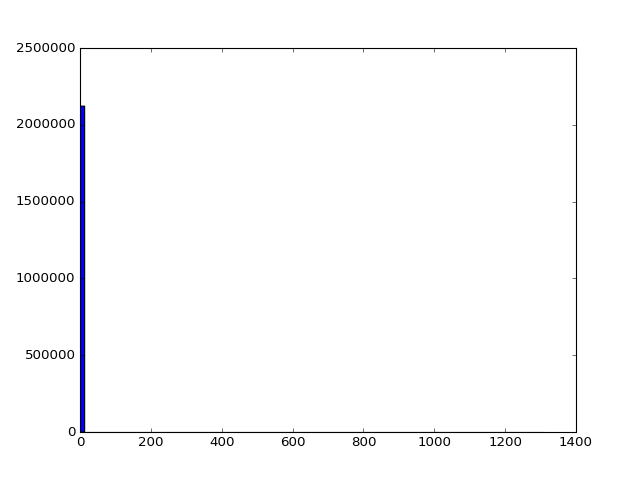

In [13]:
dec2 = decluster(arr2d, 5).ravel()
h = np.histogram(dec2, bins = 1000)[0][1:]
dec2 = process_snapshot_path('0002.png').ravel()
_ = mplt.hist(dec2, bins=100)
mplt.show()

In [27]:
%run zwo_imx291.py

## sulfur QE test

* 25-second exposure of masked S k alpha focal line from Minisoft. 
* Compare against count rate of 630/s on the Amptek.
* Gain value: 213
* Frame exposure time: .25 s

13145


<IPython.core.display.Javascript object>


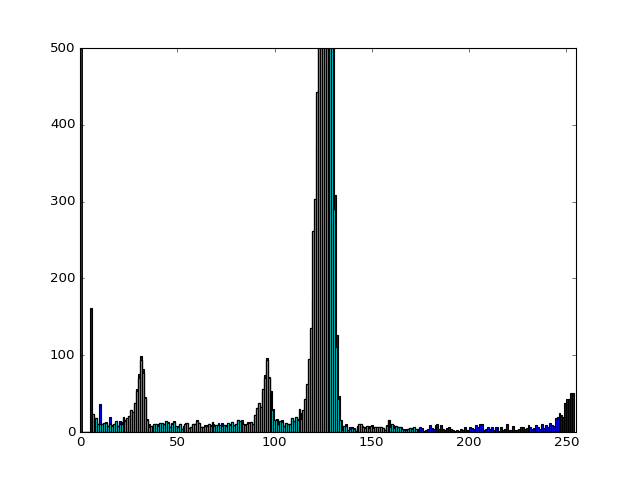

In [7]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/18_46_21.ser', threshold = 4)

In [44]:
np.sum(dec[np.logical_and(dec > 110,  dec < 170)] > 0)

9905

In [45]:
dec2 = dec.copy()
dec2[np.logical_or(dec2 > 140,  dec2 < 110)] = 0

In [48]:
plt.plot(np.sum(dec2, axis = 1), label = '')
plt.show()

## Cu k alpha

* Gain: 100

9114


<IPython.core.display.Javascript object>


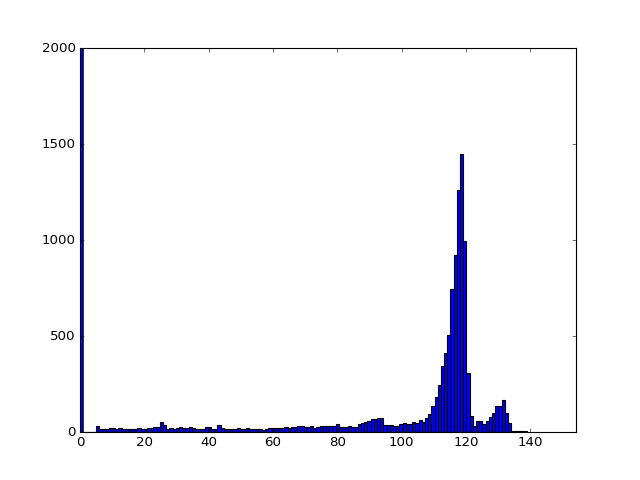

In [64]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/17_08_37.ser', threshold = 4, window_low=100, window_high=140,
                               export_path = 'imx291_Cu_K_gain_100.txt')

QE: (8852/25)/7400 = 4.7 percent

9468


<IPython.core.display.Javascript object>


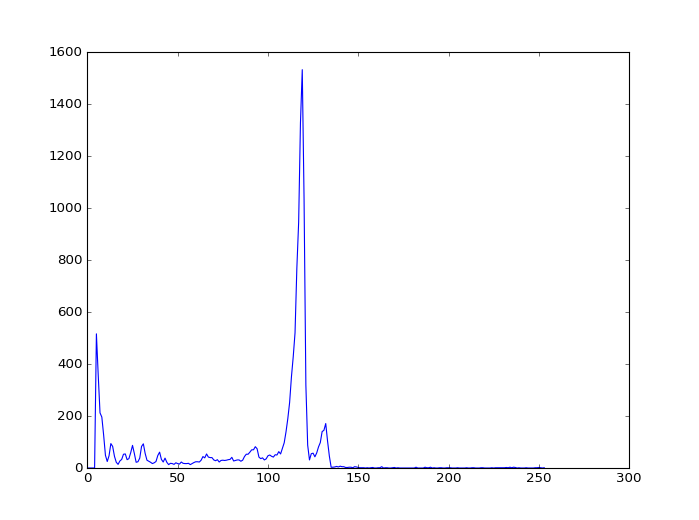

In [40]:
plt.plot(*full_process2('/media/sf_I_DRIVE/sharpcap/17_08_37.ser', threshold = 4, window_low=100,
                                window_high=140, ylim = 2000, export_path = 'imx291_Cu_ka_gain_100.txt'))

# Fe Kalpha

* gain: 100

5646


<IPython.core.display.Javascript object>


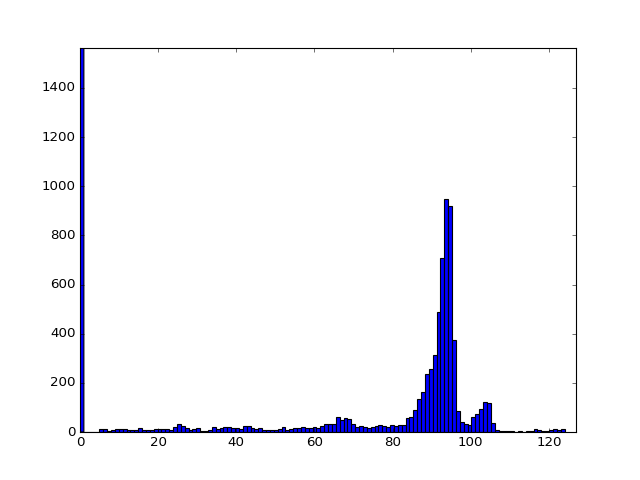

In [62]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/12_11_50.ser', threshold = 4, window_low=80, window_high=125,
                                export_path = 'imx291_Fe_K_gain_100.txt')

5133


<IPython.core.display.Javascript object>


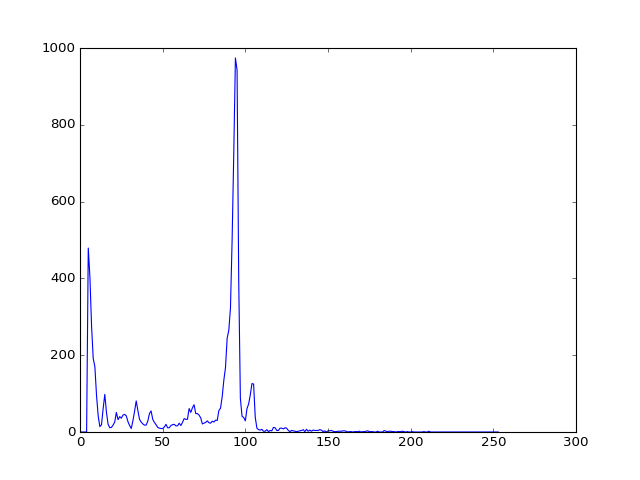

In [49]:
plt.plot(*full_process2('/media/sf_I_DRIVE/sharpcap/12_11_50.ser', threshold = 4, window_low=80,
                                window_high=100, ylim = 97, export_path = 'imx291_Fe_K_gain_100.txt'))

### QE:

In [8]:
(4737/25)/891

0.21265993265993266

# Ti Kalpha

* gain: 150

2900


<IPython.core.display.Javascript object>


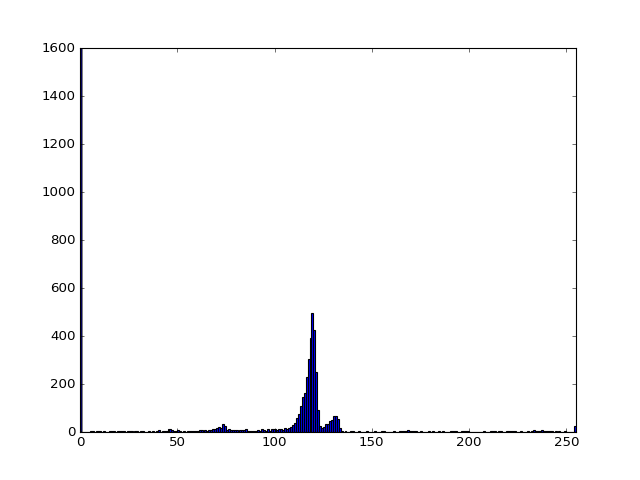

In [17]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/12_21_33.ser', threshold = 4, window_low=105, window_high=125)

2951


<IPython.core.display.Javascript object>


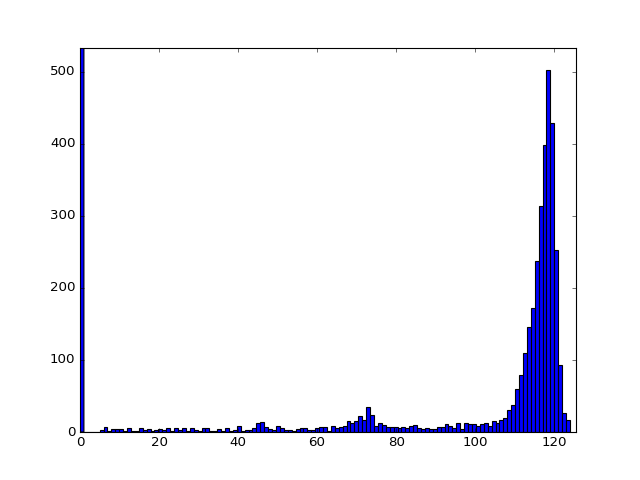

In [60]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/12_21_33.ser', threshold = 4, window_low=105, window_high=125,
                               export_path = 'imx291_Ti_K_gain_150.txt')

### Large low-energy background here. Caused by hot pixels?:

3014


<IPython.core.display.Javascript object>


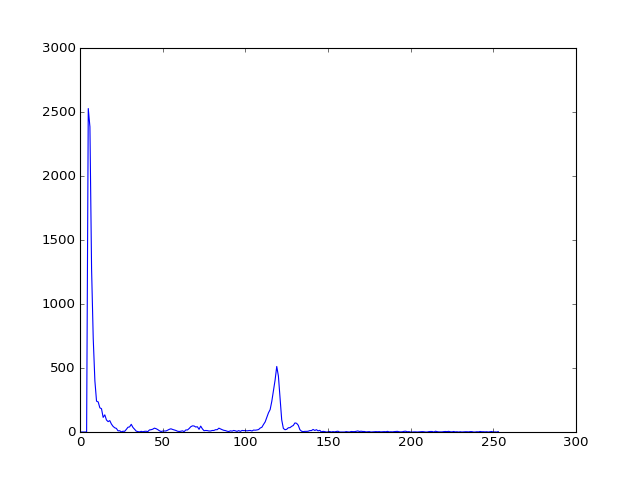

In [50]:
plt.plot(*full_process2('/media/sf_I_DRIVE/sharpcap/12_21_33.ser', threshold = 4, window_low=105, window_high=125,
                        export_path = 'imx291_Ti_K_gain_150.txt'))

In [11]:
(2900/25)/464

0.25

# Moxtek spectrum ~2-3kV
* gain: 213
* Moxtek spectrum, 4kV @ 500 uA

720


<IPython.core.display.Javascript object>


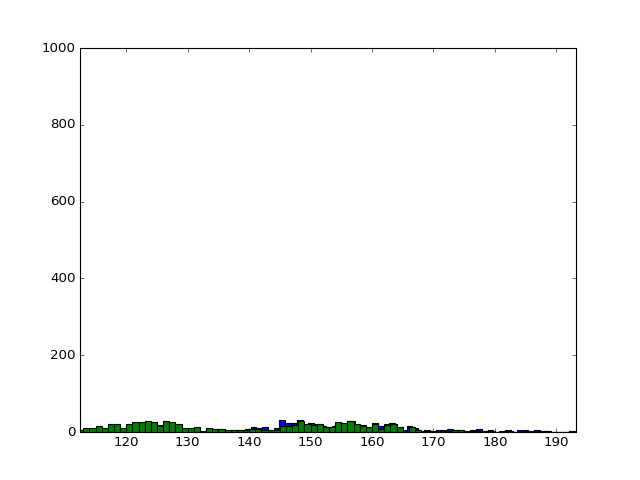

In [6]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/13_08_33.ser', threshold = 4, window_low=100, window_high=180)

In [23]:
720/25/45

0.64

2900


<IPython.core.display.Javascript object>


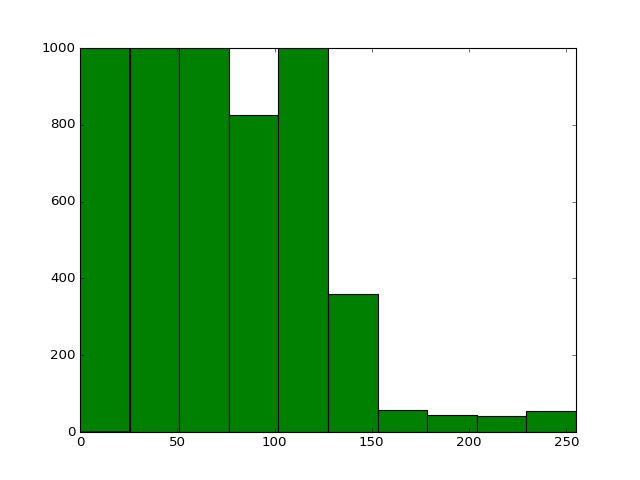

In [13]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/12_21_33.ser', threshold = 4, window_low=105, window_high=125)

<IPython.core.display.Javascript object>


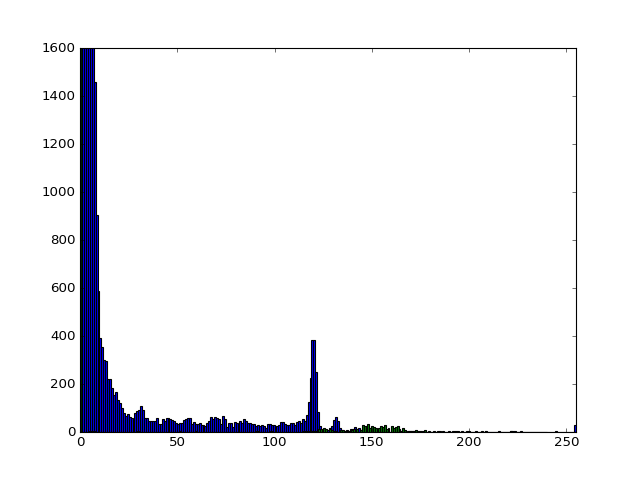

In [19]:
mplt.ylim(0, 1000)
_ =  mplt.hist(arr.ravel(), bins = 255)

# Saturation rate study (Rh ~3 keV + Bremsstrahlung)

## 10 $\mu$A:

In [ ]:
counts = [25214, 49564, 98172, 194997, 380745, 663048, 888641, 

In [41]:
223949842/(1920 * 1080)

108.00050250771605

In [39]:
!du -b /media/sf_I_DRIVE/sharpcap/15_29_19.ser

223949842	/media/sf_I_DRIVE/sharpcap/15_29_19.ser


25214


<IPython.core.display.Javascript object>


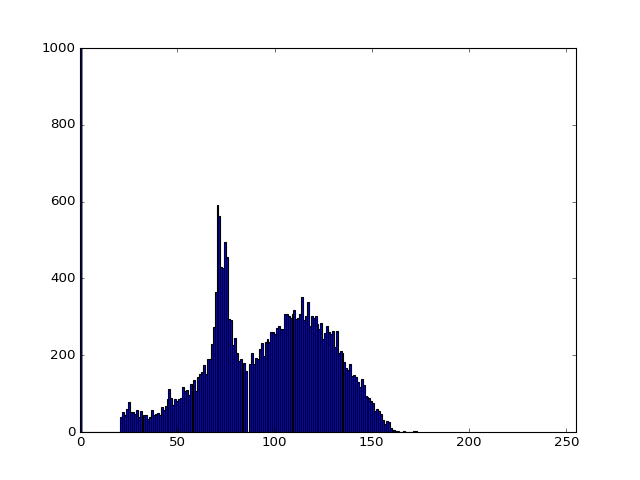

In [4]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/15_29_19.ser', threshold = 20, window_low=5,
                                window_high=175, ylim = 1000)

26436


<IPython.core.display.Javascript object>


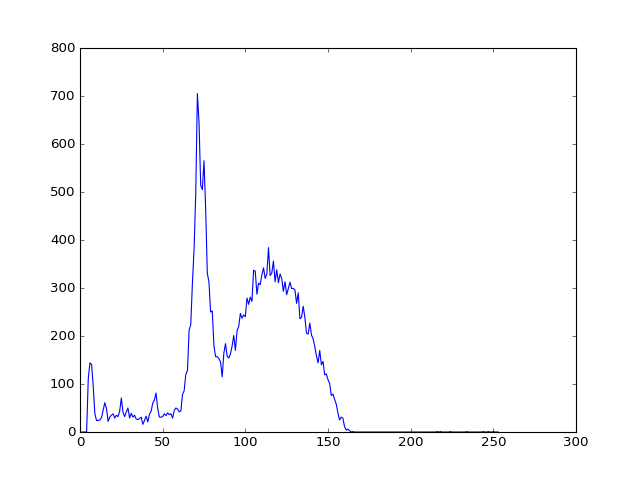

In [15]:
plt.plot(*full_process2('/media/sf_I_DRIVE/sharpcap/15_29_19.ser', threshold = 4, window_low=5,
                                window_high=175, ylim = 1000))

## 20 $\mu$A:

In [ ]:
26436, 51919, 104735, 216084, 463345, 989011, 1980855, 2938369

49564


<IPython.core.display.Javascript object>


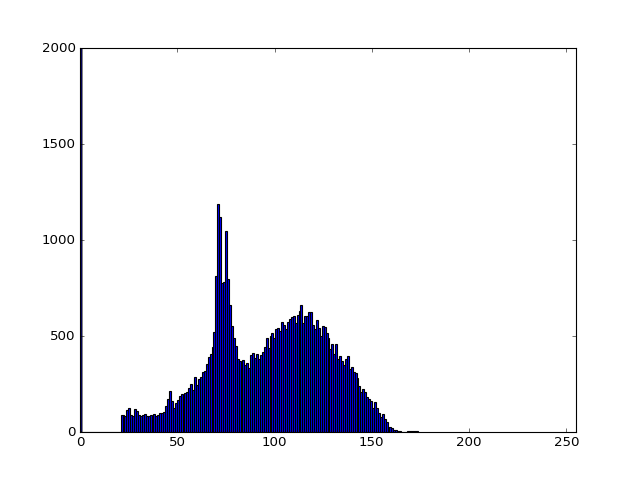

In [4]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/15_35_44.ser', threshold = 20, window_low=5,
                                window_high=175, ylim = 2000)

51919


<IPython.core.display.Javascript object>


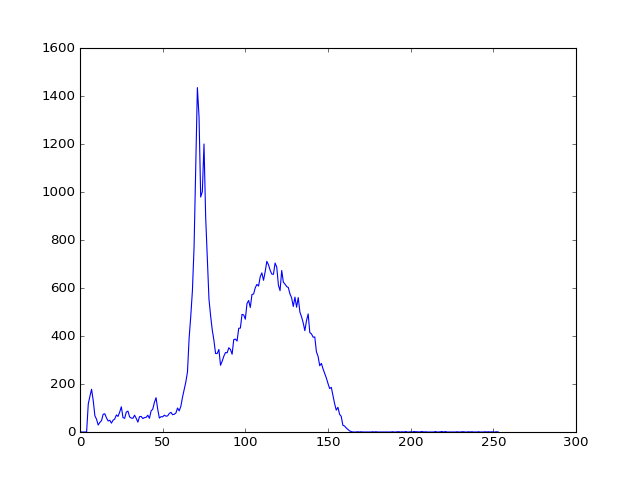

In [13]:
plt.plot(*full_process2('/media/sf_I_DRIVE/sharpcap/15_35_44.ser', threshold = 4, window_low=5,
                                window_high=175, ylim = 2000, export_path = 'test2.txt'))

## 40:

98172


<IPython.core.display.Javascript object>


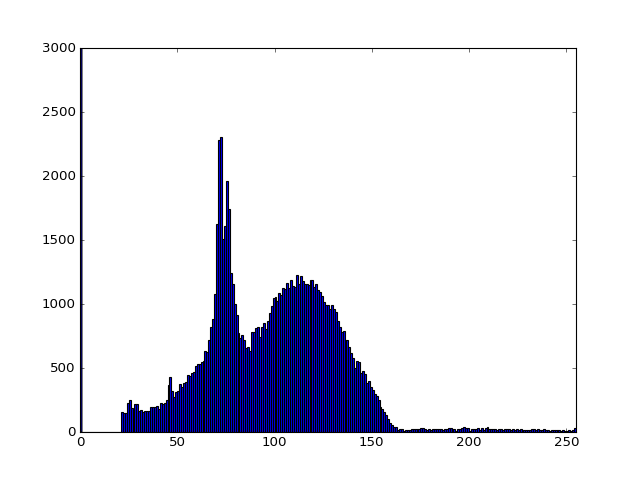

In [11]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/15_38_37.ser', threshold = 20, window_low=5,
                                window_high=175, ylim = 3000)

104735


<IPython.core.display.Javascript object>


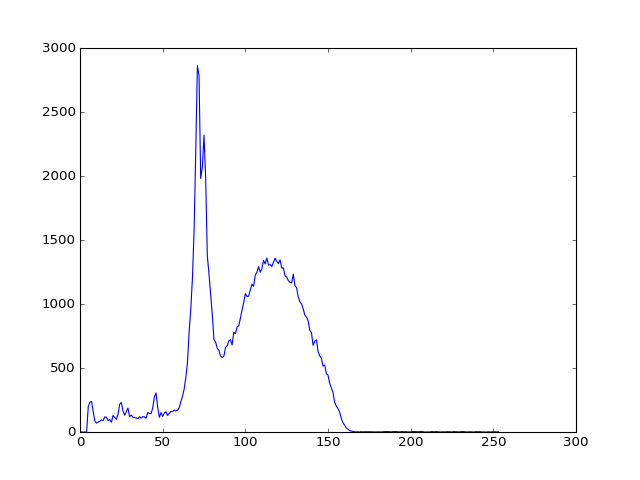

In [12]:
plt.plot(*full_process2('/media/sf_I_DRIVE/sharpcap/15_38_37.ser', threshold = 4, window_low=5,
                                window_high=175, ylim = 3000))

## 80:

194997


<IPython.core.display.Javascript object>


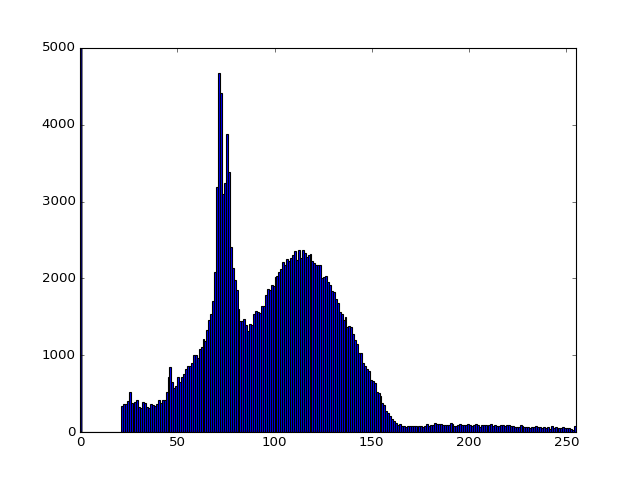

In [12]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/15_43_10.ser', threshold = 20, window_low=5,
                                window_high=175, ylim = 5000)

216084


<IPython.core.display.Javascript object>


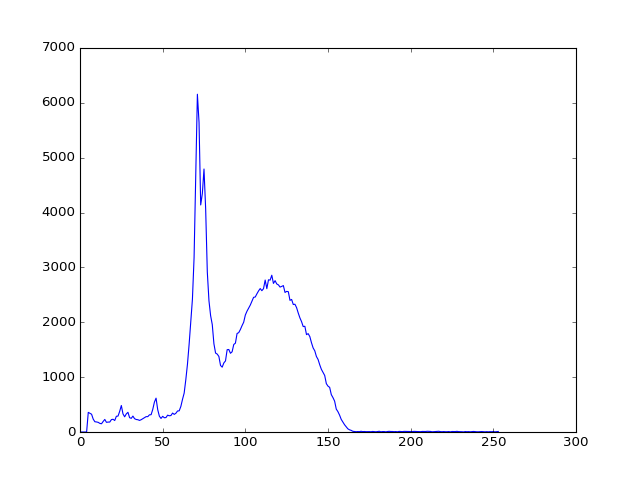

In [11]:
plt.plot(*full_process2('/media/sf_I_DRIVE/sharpcap/15_43_10.ser', threshold = 4, window_low=5,
                                window_high=175, ylim = 5000))

## 160

380745


<IPython.core.display.Javascript object>


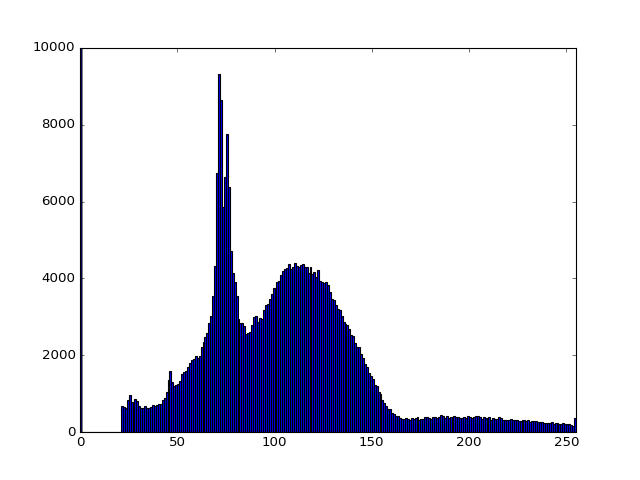

In [13]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/15_45_07.ser', threshold = 20, window_low=5,
                                window_high=175, ylim = 10000)

463345


<IPython.core.display.Javascript object>


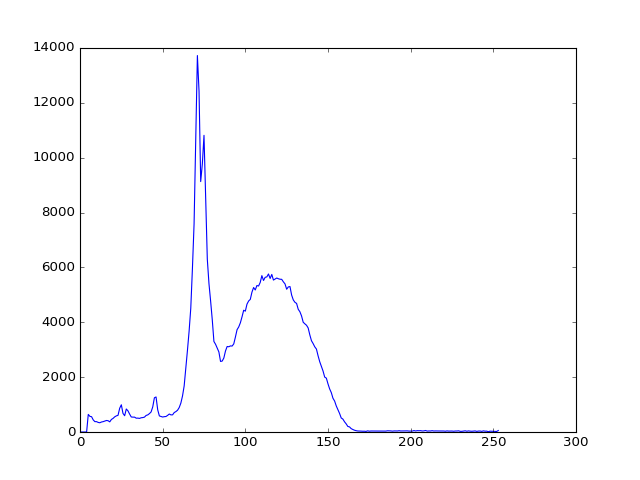

In [5]:
plt.plot(*full_process2('/media/sf_I_DRIVE/sharpcap/15_45_07.ser', threshold = 4, window_low=5,
                                window_high=175, ylim = 2000))

## 320:

In [15]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/15_48_26.ser', threshold = 20, window_low=5,
                                window_high=175)

663048


989011


<IPython.core.display.Javascript object>


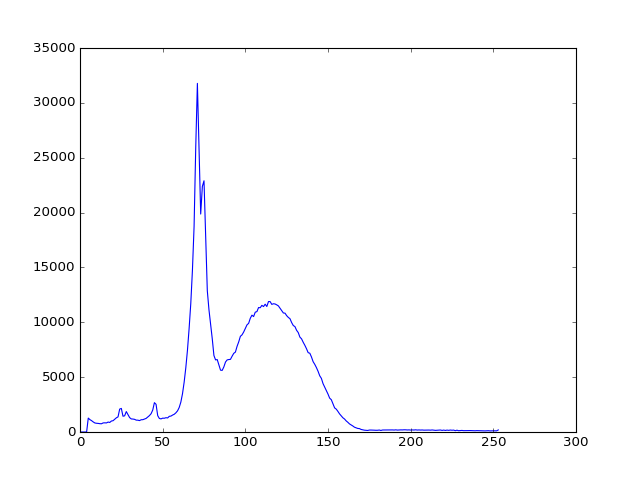

In [38]:
plt.plot(*full_process2('/media/sf_I_DRIVE/sharpcap/15_48_26.ser', threshold = 4, window_low=5,
                                window_high=175, ylim = 2000, export_path = 'imx291_tube_spectrum_6keV_320uA_gain_213.txt'))

In [ ]:
[199623, 392106, 392106, ]

## 640:

888641


<IPython.core.display.Javascript object>


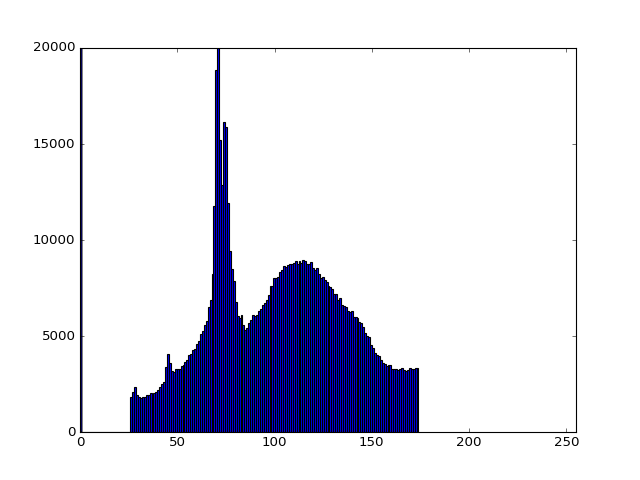

In [5]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/15_51_33.ser', threshold = 25, window_low=5,
                                window_high=175, ylim = 20000)

1980855


<IPython.core.display.Javascript object>


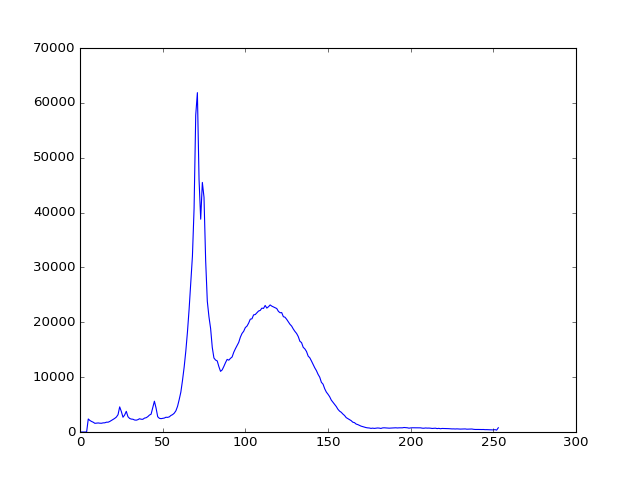

In [65]:
plt.plot(*full_process2('/media/sf_I_DRIVE/sharpcap/15_51_33.ser', threshold = 4, window_low=5,
                                window_high=175, ylim = 2000))

## 1000:

866958


<IPython.core.display.Javascript object>


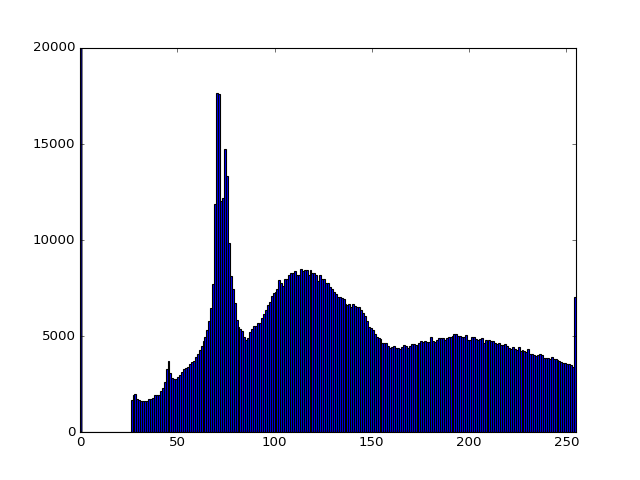

In [9]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/16_16_43.ser', threshold = 25, window_low=5,
                                window_high=175, ylim = 20000)

2938369


<IPython.core.display.Javascript object>


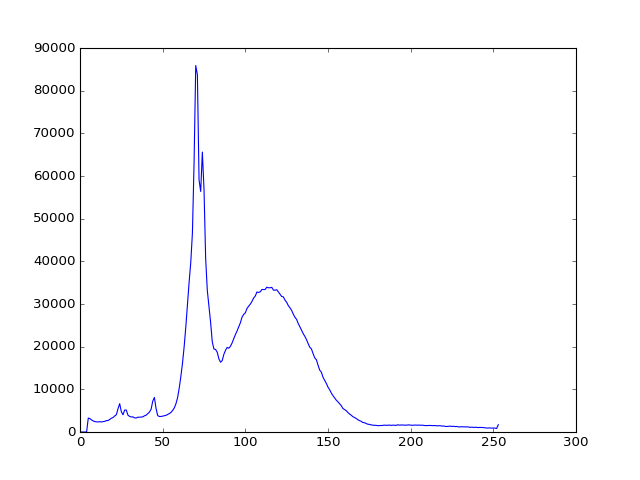

In [34]:
plt.plot(*full_process2('/media/sf_I_DRIVE/sharpcap/16_16_43.ser', threshold = 4, window_low=5,
                                window_high=175, ylim = 2000))

In [27]:
plt.show()

In [1]:
counts = [25214, 49564, 98172, 194997, 380745, 663048, 888641]
current = [10, 20, 40, 80, 160, 320, 640]

In [3]:
from xraycam.mpl_plotly import plt

In [9]:
plt.plot(current, counts, label = '')
plt.show()

## 8/15/2016

See if energy resolution is improved by increasing gain to 200; compare to Amptek spectrum.

Configuration: line of sight to Rh source running at low bias.

10990


<IPython.core.display.Javascript object>


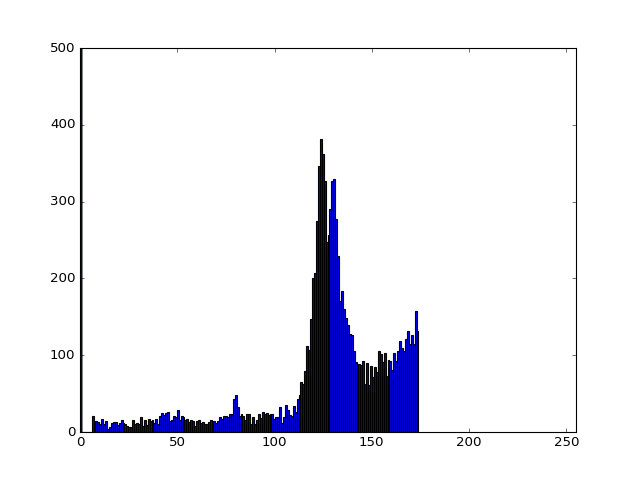

In [5]:
_, dec2, _, _ = full_process('/media/sf_I_DRIVE/sharpcap/15_53_34.ser', threshold = 5, window_low=5,
                                window_high=175, ylim = 500)

98816


<IPython.core.display.Javascript object>


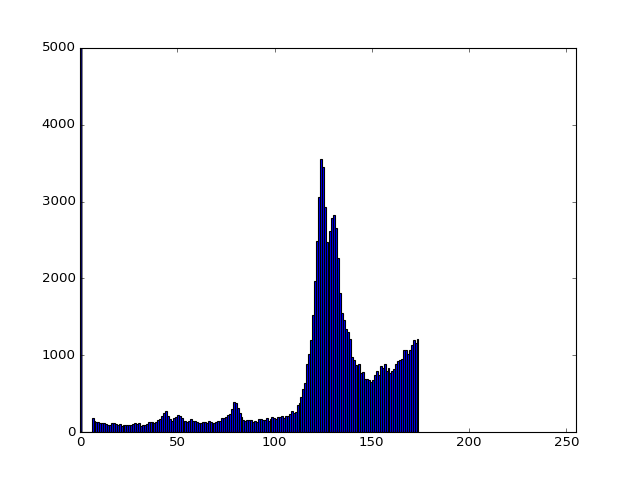

In [22]:
_, dec3, _, _ = full_process('/media/sf_I_DRIVE/sharpcap/18_01_05.ser', threshold = 5, window_low=5,
                                window_high=175, ylim = 5000)

10243


<IPython.core.display.Javascript object>


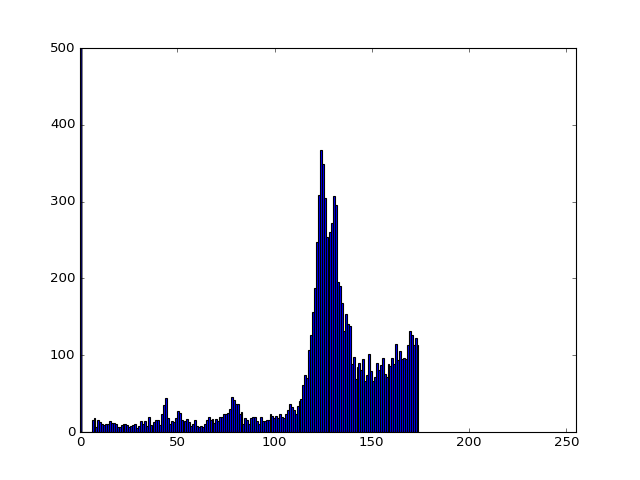

In [4]:
_, dec4, _, _ = full_process('/media/sf_I_DRIVE/sharpcap/18_06_06.ser', threshold = 5, window_low=5,
                                window_high=175, ylim = 500)

In [ ]:
arr, dec, h1, h2 = full_process('/media/sf_I_DRIVE/sharpcap/17_37_37.ser', threshold = 1, window_low=5,
                                window_high=250, ylim = 10000)

In [10]:
def arr_to_hist(arr, cutoff_low = 5, cutoff_high = 255, scale = 1., bins = None):
    low = max(cutoff_low, np.min(arr))
    high = min(cutoff_high, np.max(arr))
    if bins is None:
        bins = high - low + 1
    y, x = np.histogram(arr[np.logical_and(arr >= low, arr <= high)], bins = np.arange(low, high + 1))
    return scale * x[:-1], y
    

In [8]:
e_rh = 2697.

In [12]:
#x, y = arr_to_hist(dec, scale = scale1, cutoff_high = 254)
x2, y2 = arr_to_hist(dec2, scale = scale1, cutoff_high = 254)
x3, y3 = arr_to_hist(dec4 + dec2, scale = scale1, cutoff_high = 254)

In [11]:
scale1 = e_rh/124
scale2 = e_rh/419 - .05

In [13]:
import pandas as pd
amptek = pd.read_csv('AmptekBestResolution.csv')['0'].values
x_amptex = np.arange(np.min(amptek), np.max(amptek))

In [15]:
plt.xlabel('Energy (eV)')
plt.ylabel('Intensity (normalized)')
#plt.plot(x, y/np.max(y), label = 'CMOS camera 250uA')
#plt.plot(x2, y2/np.max(y2), label = 'CMOS camera 10uA')
plt.plot(x3, y3/np.max(y3), label = 'CMOS camera')
plt.plot(x_amptex * scale2, amptek/np.max(amptek[:500]), label = 'Amptek')

plt.show()

In [11]:
def process_plot_cmos_spectrum(path, threshold = 5, label = '', scale = 2697/124):
    plt.xlabel('Energy (eV)')
    plt.ylabel('Intensity (normalized)')
    _, dec, _, _ = full_process(path, threshold = 5, window_low=5,
        window_high=175, ylim = 500)
    x, y = arr_to_hist(dec, scale = scale, cutoff_high = 254)
    plt.plot(x, y/np.max(y), label = label)
    plt.show()

In [13]:
process_plot_cmos_spectrum('/media/sf_I_DRIVE/18_46_21.ser', scale = 2308/127)

12230
